# Are high housing costs in San Francisco a result of population growth?
Before COVID hit, the population in San Francisco was on the rise. A lot of houses are jammed together to accomodate many people in the city. Despite the high demand for housing, the cost of living in the city was extremely high. It is not surprising to say that the influx of people contributed to the rising housing prices. In this project, we aim to establish a connection between population growth and housing costs by analyzing publicly available data from the city, the US Census, and a real estate company called Zillow.

## Data
1. Population - United States Census Bureau: (API) http://api.census.gov/data/2018/pep/population.html, http://api.census.gov/data/2000/pep/int_population
2. New constructions - Building Permit: (API) https://data.sfgov.org/resource/i98e-djp9.json
3. House sale price and rent price: csv file from Zillow

<!-- Custom transformer

ColumnTransformer

Pipeline
 -->

In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import re

# sns.set()
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

## Population

In [2]:
# load data
# 2000-2010 data
response1 = requests.get('http://api.census.gov/data/2000/pep/int_population?&key=5881e53466f2caa0b924974d41daae8ca43efa29&get=DATE_,DATE_DESC,POP&for=county:075&in=state:06')
data1 = response1.json()

# 2011-2018 data 
response2 = requests.get('http://api.census.gov/data/2018/pep/population?&key=5881e53466f2caa0b924974d41daae8ca43efa29&get=DATE_CODE,DATE_DESC,POP&for=county:075&in=state:06')
data2 = response2.json()

In [3]:
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

# Custom transformer
# FunctionTransformer
# ColumnTransformer
# Pipeline

# Custom transformer: Create a dataframe
class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Nothing to learn
        # return self
        return self
    
    def transform(self, X):
        # Return a pandas data frame from X
        df1 = pd.DataFrame(X[0])
        df2 = pd.DataFrame(X[1])
        
        self.columns = df2.loc[0]
        
        X_t = df1[1:].append(df2[1:])
        X_t.columns = self.columns
        X_t.reset_index(inplace=True)
        drop_rows = [i for i in range(X_t.shape[0]) if re.search('Census|base|census',X_t.loc[i]['DATE_DESC'])]
        X_t.drop(drop_rows, inplace=True)
        X_t.drop(['index'], axis=1, inplace=True)
        return X_t


In [4]:
to_dataframe = ToDataFrame()
pop = to_dataframe.fit_transform([data1, data2])

In [5]:
pop.info()

# Data types for all cols are object
# Will extract DATE from DATE_DESC and convert to datatime type
# Will convert (DENSITY) and POP to int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 1 to 22
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   DATE_CODE  19 non-null     object
 1   DATE_DESC  19 non-null     object
 2   POP        19 non-null     object
 3   state      19 non-null     object
 4   county     19 non-null     object
dtypes: object(5)
memory usage: 912.0+ bytes


In [6]:
def to_year(date_description):
    """
    Assumes the input is a pandas Series of NOT datetime objects.
    Returns a numpy array of datetime, from 2010 t0 2018.
    """

    return np.array(date_description.apply(lambda x: pd.to_datetime(x.split(' ')[0]).year)).reshape(-1,1)

In [7]:
(to_year(pop['DATE_DESC']))

array([[2000],
       [2001],
       [2002],
       [2003],
       [2004],
       [2005],
       [2006],
       [2007],
       [2008],
       [2009],
       [2010],
       [2011],
       [2012],
       [2013],
       [2014],
       [2015],
       [2016],
       [2017],
       [2018]])

In [8]:
type(to_year(pop['DATE_DESC']))

numpy.ndarray

In [9]:
def to_num(population):
    '''
    Assumes the input is a pandas Series of object
    Returns a numpy array of integers
    '''
    return pd.to_numeric(population).to_numpy().reshape(-1,1)

In [10]:
to_num(pop['POP']).shape

(19, 1)

In [11]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

year_transformer = FunctionTransformer(to_year)
numeric_transformer = FunctionTransformer(to_num)

In [12]:
coltrans = ColumnTransformer([('date', year_transformer, 'DATE_DESC'), 
                              ('population', numeric_transformer, 'POP')])

In [13]:
coltrans.fit(pop)

ColumnTransformer(transformers=[('date',
                                 FunctionTransformer(func=<function to_year at 0x7fd5a11cf940>),
                                 'DATE_DESC'),
                                ('population',
                                 FunctionTransformer(func=<function to_num at 0x7fd5a11cf8b0>),
                                 'POP')])

In [14]:
transpipe = Pipeline([('dataframe', to_dataframe), 
                      ('columntrans',coltrans)
                      ])
population = transpipe.fit_transform([data1, data2])

In [15]:
population

array([[  2000, 777885],
       [  2001, 780865],
       [  2002, 772723],
       [  2003, 766160],
       [  2004, 761325],
       [  2005, 763016],
       [  2006, 768650],
       [  2007, 778673],
       [  2008, 791152],
       [  2009, 801922],
       [  2010, 805550],
       [  2011, 815677],
       [  2012, 829027],
       [  2013, 839841],
       [  2014, 851116],
       [  2015, 863836],
       [  2016, 872795],
       [  2017, 879166],
       [  2018, 883305]])

In [16]:
population = pd.DataFrame(population)
population.columns = ['YEAR', 'POPULATION']

In [17]:
# datetime conversion does not work in custom function with functiontransformer
# so had to convert again, need to fix it

population['YEAR'] = pd.to_datetime(population['YEAR'], format="%Y")

In [18]:
from sklearn import set_config

set_config(display="diagram")
transpipe

Pipeline(steps=[('dataframe', ToDataFrame()),
                ('columntrans',
                 ColumnTransformer(transformers=[('date',
                                                  FunctionTransformer(func=<function to_year at 0x7fd5a11cf940>),
                                                  'DATE_DESC'),
                                                 ('population',
                                                  FunctionTransformer(func=<function to_num at 0x7fd5a11cf8b0>),
                                                  'POP')]))])

In [19]:
population.to_csv('population.csv')

## House Sale Price 

In [20]:
saleprice = pd.read_csv('County-zhvi-uc-sfrcondo-tier-0.33-0.67-sm-sa-month.csv')

In [21]:
def City(data, county):
    data_sf = data[data['RegionName']==county]
    data_sf = data_sf.T
    
    data_sf = data_sf.iloc[9:]

    data_sf.index = pd.to_datetime(data_sf.index)
    
    return data_sf

In [22]:
saleSF = City(saleprice, 'San Francisco County')

In [23]:
saleSF.columns=['SF']

In [24]:
saleSF.to_csv('salesf.csv')

In [25]:
pd.read_csv('salesf.csv', index_col=0)

,SF
2000-01-31,449266.0
2000-02-29,452010.0
2000-03-31,455729.0
2000-04-30,463585.0
2000-05-31,472319.0
...,...
2022-08-31,1521568.0
2022-09-30,1489059.0
2022-10-31,1466623.0
2022-11-30,1447664.0


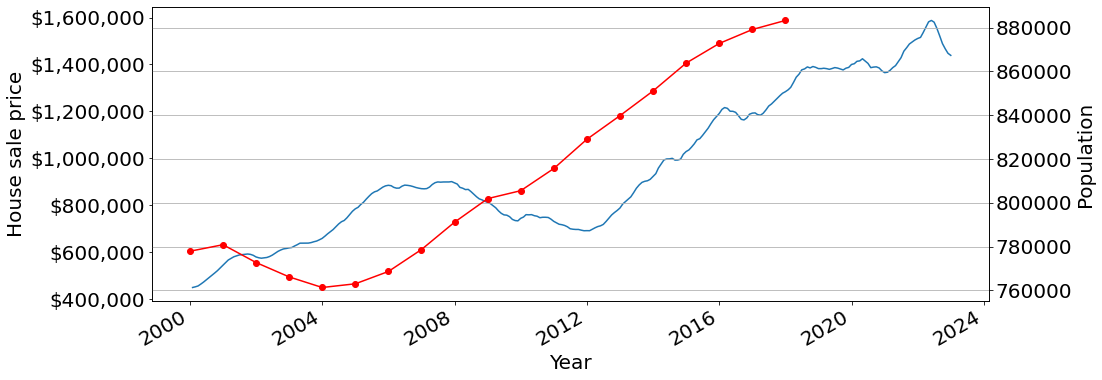

In [26]:
import datetime as dt
from matplotlib import pyplot as plt, dates as mdates


fig, ax1 = plt.subplots(figsize = (15,6))
ax1.plot(saleSF, label="Sale Price")
ax1.set_xlabel('Year')
ax1.set_ylabel('House sale price')
ax1.yaxis.set_major_formatter('${x:,.0f}')

ax2 = ax1.twinx()
ax2.plot(population['YEAR'], population['POPULATION'], 'r-o', label='Population')
ax2.set_ylabel('Population')

fig.autofmt_xdate()
plt.grid()
# plt.savefig('dual.png')
plt.show()

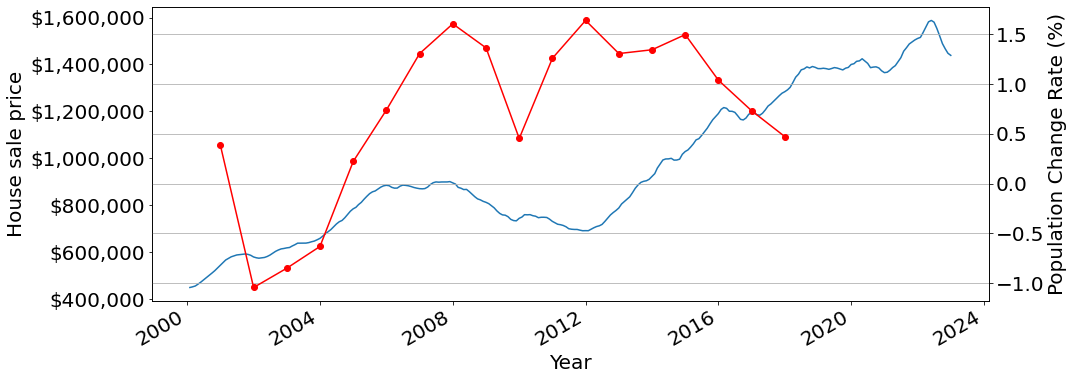

In [27]:
fig, ax1 = plt.subplots(figsize = (15,6))
ax1.plot(saleSF, label="Sale Price")
ax1.set_xlabel('Year')
ax1.set_ylabel('House sale price')
ax1.yaxis.set_major_formatter('${x:,.0f}')

ax2 = ax1.twinx()
ax2.plot(population['YEAR'], population['POPULATION'].pct_change()*100, 'r-o', label='Population Change (%)')
ax2.set_ylabel('Population Change Rate (%)')

fig.autofmt_xdate()
plt.grid()
# plt.savefig('dual_pop_chg_rate.png')
# plt.legend()
plt.show()

Since 2004, the population has been increasing, despite the financial market crash in 2008. However, it appears that the rate of increase has slowed. The house prices declined during the crash, they later rebounded with the financial recovery. There is no definitive evidence that population growth is driving the rise in house prices in San Francisco. It may be more useful to examine other counties to obtain a broader understanding of how population growth relates to house prices.

## Other counties

Let's look at other counties to see how much house sale price is related to population increase. 

In [28]:
saleprice = pd.read_csv('County-zhvi-uc-sfrcondo-tier-0.33-0.67-sm-sa-month.csv')

In [29]:
saleprice.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,2000-01-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,3101,0,Los Angeles County,county,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",6,37,217219.0,...,849467.0,867274.0,882623.0,884311.0,883805.0,870575.0,859871.0,848269.0,846262.0,845596.0
1,139,1,Cook County,county,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",17,31,173902.0,...,301166.0,303308.0,306745.0,309530.0,311511.0,311997.0,312558.0,313027.0,313775.0,312317.0
2,1090,2,Harris County,county,TX,TX,"Houston-The Woodlands-Sugar Land, TX",48,201,115286.0,...,269990.0,275086.0,280076.0,283929.0,286477.0,288032.0,288399.0,289143.0,289720.0,289591.0
3,2402,3,Maricopa County,county,AZ,AZ,"Phoenix-Mesa-Chandler, AZ",4,13,142739.0,...,457069.0,468583.0,477443.0,483784.0,481374.0,474787.0,464870.0,459841.0,454753.0,451699.0
4,2841,4,San Diego County,county,CA,CA,"San Diego-Chula Vista-Carlsbad, CA",6,73,225274.0,...,887685.0,906908.0,920069.0,919535.0,908231.0,897158.0,890169.0,885101.0,880975.0,874095.0


In [30]:
CountyCode = saleprice[['State','RegionName','Metro','StateCodeFIPS','MunicipalCodeFIPS']]
CountyCode

,State,RegionName,Metro,StateCodeFIPS,MunicipalCodeFIPS
0,CA,Los Angeles County,"Los Angeles-Long Beach-Anaheim, CA",6,37
1,IL,Cook County,"Chicago-Naperville-Elgin, IL-IN-WI",17,31
2,TX,Harris County,"Houston-The Woodlands-Sugar Land, TX",48,201
3,AZ,Maricopa County,"Phoenix-Mesa-Chandler, AZ",4,13
4,CA,San Diego County,"San Diego-Chula Vista-Carlsbad, CA",6,73
...,...,...,...,...,...
2839,CA,Alpine County,NaN,6,3
2840,CO,Hinsdale County,NaN,8,53
2841,CO,Mineral County,NaN,8,79
2842,UT,Daggett County,NaN,49,9


In [31]:
saleprice = saleprice.drop(['RegionID','SizeRank','RegionType','StateName', 'Metro', 'StateCodeFIPS','MunicipalCodeFIPS'], axis=1)

In [32]:
saleprice.set_index(['RegionName','State'], inplace =True)

In [33]:
saleprice.columns = pd.to_datetime(saleprice.columns)

In [34]:
saleprice.to_csv('sale_all.csv')

In [35]:
saleprice

,,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
RegionName,State,,,,,,,,,,,,,,,,,,,,,
Los Angeles County,CA,217219.0,217330.0,218321.0,220118.0,222354.0,224396.0,226495.0,228870.0,231025.0,232770.0,...,849467.0,867274.0,882623.0,884311.0,883805.0,870575.0,859871.0,848269.0,846262.0,845596.0
Cook County,IL,173902.0,174190.0,174862.0,176045.0,177412.0,178592.0,179931.0,181431.0,183029.0,184695.0,...,301166.0,303308.0,306745.0,309530.0,311511.0,311997.0,312558.0,313027.0,313775.0,312317.0
Harris County,TX,115286.0,115281.0,115053.0,115026.0,114974.0,115216.0,115402.0,115712.0,116115.0,116385.0,...,269990.0,275086.0,280076.0,283929.0,286477.0,288032.0,288399.0,289143.0,289720.0,289591.0
Maricopa County,AZ,142739.0,143115.0,143571.0,144468.0,145365.0,146040.0,146766.0,147457.0,148289.0,149002.0,...,457069.0,468583.0,477443.0,483784.0,481374.0,474787.0,464870.0,459841.0,454753.0,451699.0
San Diego County,CA,225274.0,226500.0,227828.0,230790.0,233629.0,237312.0,241130.0,245239.0,248848.0,252007.0,...,887685.0,906908.0,920069.0,919535.0,908231.0,897158.0,890169.0,885101.0,880975.0,874095.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Alpine County,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,534961.0,538712.0,542422.0,548593.0,557455.0,566050.0,573585.0,579363.0,NaN,550065.0
Hinsdale County,CO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,441563.0,443118.0,445850.0,454891.0,463651.0,473080.0,475959.0,479312.0,469611.0,459053.0
Mineral County,CO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,380127.0,382103.0,385765.0,393501.0,399756.0,405392.0,407476.0,408416.0,401934.0,393469.0


In [36]:
# load data

response1 = requests.get('http://api.census.gov/data/2000/pep/int_population?&key=5881e53466f2caa0b924974d41daae8ca43efa29&get=DATE_,DATE_DESC,POP&for=county&for=state')
data1 = response1.json()

response2 = requests.get('http://api.census.gov/data/2018/pep/population?&key=5881e53466f2caa0b924974d41daae8ca43efa29&get=DATE_CODE,DATE_DESC,POP,DENSITY&for=county&for=state')
data2 = response2.json()

In [37]:
df_data1 = pd.DataFrame(data1)
df_data1.head()

,0,1,2,3,4
0,DATE_,DATE_DESC,POP,state,county
1,1,4/1/2000 population estimates base,73943,23,003
2,2,7/1/2000 population estimate,73872,23,003
3,3,7/1/2001 population estimate,72962,23,003
4,4,7/1/2002 population estimate,72942,23,003


In [38]:
df_data2 = pd.DataFrame(data2)
df_data2.head()

,0,1,2,3,4,5
0,DATE_CODE,DATE_DESC,POP,DENSITY,state,county
1,1,4/1/2010 Census population,54571,91.801792838,01,001
2,2,4/1/2010 population estimates base,54574,91.806839573,01,001
3,3,7/1/2010 population estimate,54754,92.109643676,01,001
4,4,7/1/2011 population estimate,55208,92.873382914,01,001


In [39]:
drop_rows = [i for i in range(df_data1.shape[0]) if re.search('Census|base|census',df_data1.loc[i][1])]
df_data1.drop(drop_rows, inplace=True)

In [40]:
df_data1.reset_index(inplace = True)
df_data1.columns = df_data1.loc[0]
df_data1.drop(0, inplace=True)
df_data1['YEAR'] = df_data1['DATE_DESC'].apply(lambda x: x.split(' ')[0]).apply(lambda x:x.split('/')[2])
df_data1

,0,DATE_,DATE_DESC,POP,state,county,YEAR
1,2,2,7/1/2000 population estimate,73872,23,003,2000
2,3,3,7/1/2001 population estimate,72962,23,003,2001
3,4,4,7/1/2002 population estimate,72942,23,003,2002
4,5,5,7/1/2003 population estimate,72944,23,003,2003
5,6,6,7/1/2004 population estimate,72959,23,003,2004
...,...,...,...,...,...,...,...
32206,38647,7,7/1/2005 population estimate,44775,72,153,2005
32207,38648,8,7/1/2006 population estimate,44242,72,153,2006
32208,38649,9,7/1/2007 population estimate,43640,72,153,2007
32209,38650,10,7/1/2008 population estimate,43047,72,153,2008


In [41]:
df_data1.drop([0,'DATE_','DATE_DESC'], axis=1, inplace=True)
df_data1.head()

,POP,state,county,YEAR
1,73872,23,003,2000
2,72962,23,003,2001
3,72942,23,003,2002
4,72944,23,003,2003
5,72959,23,003,2004


In [42]:
drop_rows = [i for i in range(df_data2.shape[0]) if re.search('Census|base|census',df_data2.loc[i][1])]
df_data2.drop(drop_rows, inplace=True)

In [43]:
df_data2.head()

,0,1,2,3,4,5
0,DATE_CODE,DATE_DESC,POP,DENSITY,state,county
3,3,7/1/2010 population estimate,54754,92.109643676,01,001
4,4,7/1/2011 population estimate,55208,92.873382914,01,001
5,5,7/1/2012 population estimate,54936,92.415812269,01,001
6,6,7/1/2013 population estimate,54713,92.04067163,01,001


In [44]:
df_data2.reset_index(inplace = True)
df_data2.columns = df_data2.loc[0]
df_data2.drop(0, inplace=True)
df_data2['YEAR'] = df_data2['DATE_DESC'].apply(lambda x: x.split(' ')[0]).apply(lambda x:x.split('/')[2])
df_data2.head()

,0,DATE_CODE,DATE_DESC,POP,DENSITY,state,county,YEAR
1,3,3,7/1/2010 population estimate,54754,92.109643676,01,001,2010
2,4,4,7/1/2011 population estimate,55208,92.873382914,01,001,2011
3,5,5,7/1/2012 population estimate,54936,92.415812269,01,001,2012
4,6,6,7/1/2013 population estimate,54713,92.04067163,01,001,2013
5,7,7,7/1/2014 population estimate,54876,92.314877568,01,001,2014


In [45]:
df_data2.drop([0,'DATE_CODE','DATE_DESC'], axis=1, inplace=True)
df_data2.head()

,POP,DENSITY,state,county,YEAR
1,54754,92.109643676,01,001,2010
2,55208,92.873382914,01,001,2011
3,54936,92.415812269,01,001,2012
4,54713,92.04067163,01,001,2013
5,54876,92.314877568,01,001,2014


In [46]:
df = df_data1.append(df_data2)

In [47]:
df.reset_index(drop=True, inplace=True)

In [48]:
CountyCode.head()

,State,RegionName,Metro,StateCodeFIPS,MunicipalCodeFIPS
0,CA,Los Angeles County,"Los Angeles-Long Beach-Anaheim, CA",6,37
1,IL,Cook County,"Chicago-Naperville-Elgin, IL-IN-WI",17,31
2,TX,Harris County,"Houston-The Woodlands-Sugar Land, TX",48,201
3,AZ,Maricopa County,"Phoenix-Mesa-Chandler, AZ",4,13
4,CA,San Diego County,"San Diego-Chula Vista-Carlsbad, CA",6,73


In [49]:
df.columns=['Population','StateCodeFIPS','MunicipalCodeFIPS','Year', 'Density']
df.head()

,Population,StateCodeFIPS,MunicipalCodeFIPS,Year,Density
0,73872,23,003,2000,NaN
1,72962,23,003,2001,NaN
2,72942,23,003,2002,NaN
3,72944,23,003,2003,NaN
4,72959,23,003,2004,NaN


In [50]:
df['StateCodeFIPS'] = df['StateCodeFIPS'].astype(int)
df['MunicipalCodeFIPS'] = df['MunicipalCodeFIPS'].astype(int)

In [51]:
pop = pd.merge(df, CountyCode, on=['StateCodeFIPS','MunicipalCodeFIPS'], how='left')

In [52]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61190 entries, 0 to 61189
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Population         61190 non-null  object
 1   StateCodeFIPS      61190 non-null  int64 
 2   MunicipalCodeFIPS  61190 non-null  int64 
 3   Year               61190 non-null  object
 4   Density            28278 non-null  object
 5   State              54036 non-null  object
 6   RegionName         54036 non-null  object
 7   Metro              34257 non-null  object
dtypes: int64(2), object(6)
memory usage: 4.2+ MB


In [53]:
pop = pop.set_index(['RegionName','State'])

In [54]:
pop['Year'] = pd.to_datetime(pop['Year'])

In [55]:
pop['Population'] = pop['Population'].astype(int)
pop['Density'] = pop['Density'].astype(float)

In [56]:
from ipywidgets import widgets

x1 = saleprice.columns
Y1 = saleprice
x2 = pop['Year'].unique()
Y2 = pop['Population']

def price_pop_plot(x1, Y1, x2, Y2):
    def plotter(County):
        
        fig, ax1 = plt.subplots(figsize = (10,6))
        ax1.plot(x1, Y1.loc[County, x1], '.-', color='k', label='House Price')
        
        ax2 = ax1.twinx()
        ax2.plot(x2, Y2.loc[County], '>-', color='b', label='Population')
        
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Home price ($)')
        ax2.set_ylabel('Population')
        
        
        plt.show()
    
    return plotter

dropdown_values = {f"{county}": county for county in sorted(list(Y1.index))}
widgets.interact(price_pop_plot(x1, Y1, x2, Y2), County=dropdown_values);


interactive(children=(Dropdown(description='County', options={"('Abbeville County', 'SC')": ('Abbeville County…

Not all counties have complete data for the period. In some counties, house prices and population exhibit opposing trends. It is not always accurate to assume that house prices increase in tandem with population growth or that population growth drives house prices up.

## Correlation

In [57]:
saleprice_fillna = saleprice.fillna(method='ffill', axis=1)

In [58]:
saleprice_yearly = saleprice_fillna.loc[:][saleprice.columns[5::12]]
saleprice_yearly.loc['New York County','NY']

2000-06-30     397647.0
2001-06-30     473619.0
2002-06-30     538353.0
2003-06-30     590468.0
2004-06-30     716140.0
2005-06-30     862812.0
2006-06-30    1015370.0
2007-06-30     952562.0
2008-06-30     955312.0
2009-06-30     953506.0
2010-06-30     858964.0
2011-06-30     922126.0
2012-06-30     936302.0
2013-06-30     988056.0
2014-06-30    1119332.0
2015-06-30    1210635.0
2016-06-30    1254740.0
2017-06-30    1250509.0
2018-06-30    1299293.0
2019-06-30    1278685.0
2020-06-30    1226612.0
2021-06-30    1213850.0
2022-06-30    1331240.0
Name: (New York County, NY), dtype: float64

In [59]:
corr = {}
for county in list(Y1.index):
    coef = np.corrcoef(pop.loc[county]['Population'],saleprice_yearly.loc[county][:19])
    corr[county] = (coef[1][0], pop.loc[county]['Population'][-1], saleprice_yearly.loc[county][18], pop.loc[county]['Density'][-1],
                   (pop.loc[county]['Population'][-1]-pop.loc[county]['Population'][0])/pop.loc[county]['Population'][0],
                   (saleprice_yearly.loc[county][18]-saleprice_yearly.loc[county][0])/saleprice_yearly.loc[county][0]) 

<ipython-input-59-7d8825cea850>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  coef = np.corrcoef(pop.loc[county]['Population'],saleprice_yearly.loc[county][:19])
<ipython-input-59-7d8825cea850>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  corr[county] = (coef[1][0], pop.loc[county]['Population'][-1], saleprice_yearly.loc[county][18], pop.loc[county]['Density'][-1],
<ipython-input-59-7d8825cea850>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  (pop.loc[county]['Population'][-1]-pop.loc[county]['Population'][0])/pop.loc[county]['Population'][0],


In [60]:
corr_df = pd.DataFrame(corr).T
corr_df.columns=['Correlation Coefficient', 'Population', 'Sale Price', 'Density', 'Population Increase Rate', 'Sale Price Increase Rate']
corr_df

,,Correlation Coefficient,Population,Sale Price,Density,Population Increase Rate,Sale Price Increase Rate
Los Angeles County,CA,0.602012,10105518.0,628852.0,2490.152001,0.059480,1.802421
Cook County,IL,-0.712629,5180493.0,246759.0,5482.379133,-0.035904,0.381691
Harris County,TX,0.867648,4698619.0,192943.0,2755.460466,0.376183,0.674620
Maricopa County,AZ,0.382181,4410824.0,261453.0,479.476430,0.426437,0.790283
San Diego County,CA,0.460948,3343364.0,575416.0,794.381356,0.182501,1.424724
...,...,...,...,...,...,...,...
Alpine County,CA,NaN,1101.0,421724.0,1.491182,-0.089330,NaN
Hinsdale County,CO,NaN,811.0,NaN,0.725902,0.025284,NaN
Mineral County,CO,NaN,776.0,NaN,0.886087,-0.067308,NaN
Daggett County,UT,NaN,980.0,204559.0,1.406054,0.058315,NaN


In [61]:
corr_df.loc[county]

Correlation Coefficient               NaN
Population                     762.000000
Sale Price                  284755.000000
Density                          1.966373
Population Increase Rate         0.355872
Sale Price Increase Rate              NaN
Name: (San Juan County, CO), dtype: float64

In [62]:
corr_df_dropna = corr_df.dropna()

In [63]:
# corr_df_dropna.to_csv('corr.csv')

In [64]:
z = np.polyfit(corr_df_dropna[corr_df_dropna['Population Increase Rate']<0.25]['Population Increase Rate'], corr_df_dropna[corr_df_dropna['Population Increase Rate']<0.25]['Correlation Coefficient'], 1)
p = np.poly1d(z)
xp = np.linspace(-0.25, 0.25,20)

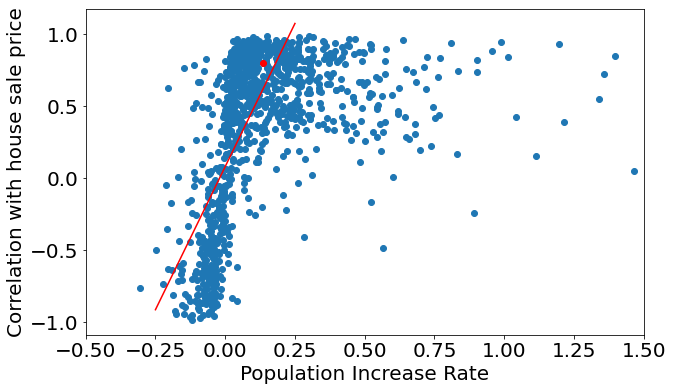

In [65]:
county = ('San Francisco County','CA')
plt.subplots(figsize=(10,6))
plt.scatter(corr_df_dropna['Population Increase Rate'], corr_df_dropna['Correlation Coefficient'])
plt.xlim((-0.5, 1.5))
plt.plot(xp, p(xp), 'r')
plt.scatter(corr_df_dropna.loc[county]['Population Increase Rate'], corr_df_dropna.loc[county]['Correlation Coefficient'], color='r')
plt.ylabel('Correlation with house sale price')
plt.xlabel('Population Increase Rate')
plt.show()

For some counties, the correlation between population growth and house prices is not particularly strong, indicating that population increase may not be the sole primary factor driving housing prices. In some other counties, there is even a negative correlation. In San Francisco (depicted by the red dot), the correlation coefficient is a relatively high 0.79. Generally, counties with higher rates of population growth tend to display higher correlations, and San Francisco is among them.

## House Price and Population Density

In [66]:
# Correlation between density and house price

den = []
pri = []

for county in list(Y1.index):
    d = pop.loc[county]['Density'][-1]
    p = saleprice_yearly.loc[county][-1]
    if str(d) != 'nan' and str(p) != 'nan':
        den.append(d)
        pri.append(p)
    
np.corrcoef(den, pri)

<ipython-input-66-dc53db3501f3>:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = pop.loc[county]['Density'][-1]


array([[1.        , 0.27179748],
       [0.27179748, 1.        ]])

In [67]:
z = np.polyfit(den, pri, 1)
p = np.poly1d(z)
xp = np.linspace(0,5000,200)

<ipython-input-68-81f05dddcd7f>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.scatter(pop.loc['San Francisco County','CA']['Density'][-1], saleprice_yearly.loc['San Francisco County','CA'][-1], color='r')


Text(0, 0.5, 'House Price ($)')

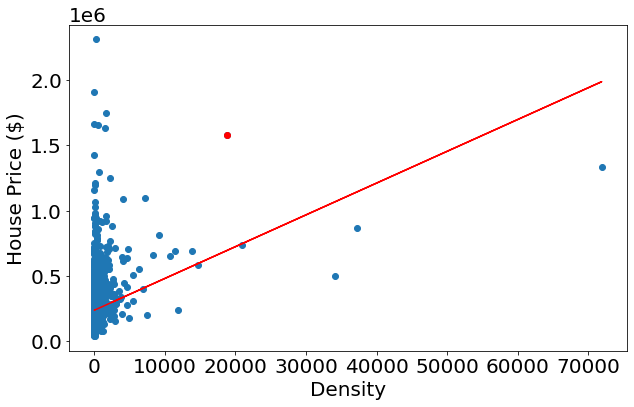

In [68]:
plt.subplots(figsize=(10,6))
plt.plot(den, p(den), 'r')
plt.scatter(den, pri)
plt.scatter(pop.loc['San Francisco County','CA']['Density'][-1], saleprice_yearly.loc['San Francisco County','CA'][-1], color='r')
plt.xlabel('Density')
plt.ylabel('House Price ($)')

As a general trend, there is a positive correlation between population density and house prices. San Francisco (red dot), however, is an outlier, as it falls far from the fitting line. When compared to counties in the New York Area (dots with a density greater than 30000), the housing prices in San Francisco appear significantly higher. While the combination of high population density and population growth may influence high housing prices, it is apparent that they are not the only primary factors contributing to San Francisco's elevated housing prices.

## New constructions and extensions

With the continuous population growth, the scarcity of available residential units may contribute to a rise in housing costs. By examining city permit data, we can determine whether San Francisco has been providing new residential units to accommodate the influx of new residents.

In [69]:
## Building Permit

## It takes long time to load data to dataframe, so data for constructions completed since 2000 were saved into a csv file

# response = requests.get('https://data.sfgov.org/resource/i98e-djp9.json?$limit=1500000')

# df = pd.DataFrame(requests.get('https://data.sfgov.org/resource/i98e-djp9.json?$limit=1500000').json())
# df.dropna(subset=['completed_date'],inplace=True)
# df = df[df['completed_date'].str.match('20')]
# # df.to_csv('permit.csv')
# permit_df = df

In [70]:
permit_df = pd.read_csv('permit.csv', index_col=0)

In [71]:
permit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442643 entries, 205 to 1206412
Data columns (total 53 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   permit_number                           442643 non-null  object
 1   permit_type                             442643 non-null  object
 2   permit_type_definition                  442643 non-null  object
 3   permit_creation_date                    442643 non-null  object
 4   block                                   442643 non-null  object
 5   lot                                     442643 non-null  object
 6   street_number                           442643 non-null  object
 7   street_name                             442643 non-null  object
 8   street_suffix                           435765 non-null  object
 9   description                             442381 non-null  object
 10  status                                  442643 non-nu

In [72]:
permit_df.head()

,permit_number,permit_type,permit_type_definition,permit_creation_date,block,lot,street_number,street_name,street_suffix,description,...,revised_cost,unit,unit_suffix,site_permit,fire_only_permit,first_construction_document_date,street_number_suffix,structural_notification,tidf_compliance,voluntary_soft_story_retrofit
205,200106060934,8,otc alterations permit,2001-06-06T00:00:00.000,3566,037,3684,17th,St,reroofing,...,9500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,200106060934,8,otc alterations permit,2001-06-06T00:00:00.000,3566,037,3686,17th,St,reroofing,...,9500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,202103025652,8,otc alterations permit,2021-03-02T00:00:00.000,1199,037,1562,Hayes,St,dry rot repair at rear deck less than 50%. (pe...,...,8400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1078,200403017444,7,wall or painted sign,2004-03-01T00:00:00.000,1761,035,555,Irving,St,painted non-structural sign,...,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1186,9718181,6,demolitions,1997-09-17T00:00:00.000,4228,002,1200,Minnesota,St,demolition of two story office bldg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
permit_df.columns

Index(['permit_number', 'permit_type', 'permit_type_definition',
       'permit_creation_date', 'block', 'lot', 'street_number', 'street_name',
       'street_suffix', 'description', 'status', 'status_date', 'filed_date',
       'issued_date', 'completed_date', 'number_of_existing_stories',
       'number_of_proposed_stories', 'permit_expiration_date',
       'estimated_cost', 'existing_use', 'existing_units', 'proposed_use',
       'proposed_units', 'plansets', 'existing_construction_type',
       'existing_construction_type_description', 'proposed_construction_type',
       'proposed_construction_type_description', 'supervisor_district',
       'neighborhoods_analysis_boundaries', 'zipcode', 'location', 'record_id',
       ':@computed_region_6qbp_sg9q', ':@computed_region_qgnn_b9vv',
       ':@computed_region_26cr_cadq', ':@computed_region_ajp5_b2md',
       ':@computed_region_bh8s_q3mv', ':@computed_region_yftq_j783',
       ':@computed_region_rxqg_mtj9', ':@computed_region_jx4q_fiz

In [74]:
permit_df.status.value_counts()

complete      440183
expired         1555
issued           651
reinstated       125
suspend           54
cancelled         36
revoked           31
approved           4
withdrawn          2
inspection         1
incomplete         1
Name: status, dtype: int64

In [75]:
permit_df['permit_type_definition'].unique()

array(['otc alterations permit', 'wall or painted sign', 'demolitions',
       'new construction', 'new construction wood frame',
       'grade or quarry or fill or excavate',
       'additions alterations or repairs', 'sign - erect'], dtype=object)

In [76]:
permit_df['proposed_use'].unique()

array(['apartments', '1 family dwelling', nan, 'prkng garage/public',
       '2 family dwelling', 'office', 'school', 'artist live/work',
       'retail sales', 'tourist hotel/motel', 'church',
       'lending institution', 'public assmbly other', 'theater',
       'parking lot', 'food/beverage hndlng', 'not applicable',
       'auto repairs', 'car wash', 'club', 'workshop commercial',
       'health studios & gym', 'museum', 'sfpd or sffd station',
       'warehouse,no frnitur', 'misc group residns.', 'printing plant',
       'warehouse, furniture', 'residential hotel', 'nursing home gt 6',
       'nursing home non amb', 'recreation bldg', 'clinics-medic/dental',
       'dance hall', 'fence/retaining wall', 'filling/service stn',
       'prkng garage/private', 'vacant lot', 'storage shed',
       'nursing home lte 6', 'day care home gt 12', 'garment shops',
       'manufacturing', 'animal sale or care', 'day care, non-res',
       'workshop residential', 'day care home 7 - 12', 'jail'

In [77]:
permit_count = permit_df.groupby('permit_type_definition')['permit_number'].count()

In [78]:
# permit_df[(permit_df['street_name']=='03rd') & (permit_df['street_number']=='148')].iloc[1]

In [79]:
new_constr_cnt = pd.DataFrame(permit_count).T
new_constr_col = ['new construction','additions alterations or repairs','new construction wood frame']
new_constr_cnt = new_constr_cnt[new_constr_col]
new_constr_cnt

permit_type_definition,new construction,additions alterations or repairs,new construction wood frame
permit_number,624,50748,3444


In [80]:
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline

class ToDataFrame(BaseEstimator, TransformerMixin):
    '''
    output pandas dataframe
    
    '''
    def fit(self, X, y=None):
        self.dtype = type(X)
        return self
    
    def transform(self, X):
        if self.dtype == pd.DataFrame:
            return X
        else:
            return pd.DataFrame(X)
    

In [81]:
class NewConstr(BaseEstimator, TransformerMixin):
    '''
    output a dataframe that include new constructions for residential units
    '''
    
    residential = ['apartments', '2 family dwelling','1 family dwelling']
    new_constr_col = ['new construction','additions alterations or repairs','new construction wood frame']
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
#         df[df['permit_type_definition'].isin(new_constr_col) & (df['status']=='complete')]
        return X[(X['permit_type_definition'].isin(new_constr_col)) & (X['status']=='complete') & (X['proposed_use'].isin(['apartments', '2 family dwelling','1 family dwelling']))]

In [82]:
def to_year(date_col):
    '''
    used in function transformer
    '''
    return np.array(date_col.apply(lambda x: pd.to_datetime(x).year)).reshape(-1,1)

#     return date_col.apply(lambda x: pd.to_datetime(x).year)

In [83]:
def to_int(unit_col):
    '''
    used in function transformer
    '''
    return unit_col.fillna(0).astype(int)

In [84]:
class DropRows(BaseEstimator, TransformerMixin):
    '''
    drop nan rows
    '''
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = pd.DataFrame(X)
        df.columns = ['year','permit_type_definition', 'status','proposed_use','proposed_units','existing_units']
        df['existing_units'].fillna(0, inplace = True)
        df['proposed_units'].fillna(0, inplace = True)
        return df


In [85]:
class CountUnits(BaseEstimator, TransformerMixin):
    '''
    input: dataframe
    output: dataframe, counts units from new constructions
    '''
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.groupby(['year'])[['existing_units','proposed_units']].sum()

In [86]:
class UnitSupplied(BaseEstimator, TransformerMixin):
    '''
    input: two dataframes for newly built residential units & previous units
    output: a dataframe for increased number of units
    '''
    def fit(self, X, y=None):
        return self
    def transform(self, X):        
        return pd.DataFrame({'Units Supplied': X['proposed_units']-X['existing_units']})

In [87]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

to_dataframe = ToDataFrame()
new_constr = NewConstr()
count_units = CountUnits()
drop_rows = DropRows()
units_supplied = UnitSupplied()

coltrans = ColumnTransformer([('to_year', FunctionTransformer(to_year), 'completed_date'),
                             ('passthrough', 'passthrough',['permit_type_definition', 'status','proposed_use']),
                             ('to_int', FunctionTransformer(to_int), ['proposed_units','existing_units'])
                             ])


In [88]:
pipe = Pipeline([('todataframe', to_dataframe),
                ('newconstr', new_constr),
                ('coltrans', coltrans),
                ('droprows', drop_rows),
                ('unit', count_units),
                ('units', units_supplied)
                ])

In [89]:
result = pipe.fit_transform(permit_df)

In [90]:
result = pd.DataFrame(result)

In [91]:
from sklearn import set_config

set_config(display="diagram")
pipe

Pipeline(steps=[('todataframe', ToDataFrame()), ('newconstr', NewConstr()),
                ('coltrans',
                 ColumnTransformer(transformers=[('to_year',
                                                  FunctionTransformer(func=<function to_year at 0x7fd5bb3c6d30>),
                                                  'completed_date'),
                                                 ('passthrough', 'passthrough',
                                                  ['permit_type_definition',
                                                   'status', 'proposed_use']),
                                                 ('to_int',
                                                  FunctionTransformer(func=<function to_int at 0x7fd5bb3c6c10>),
                                                  ['proposed_units',
                                                   'existing_units'])])),
                ('droprows', DropRows()), ('unit', CountUnits()),
                ('units', UnitSupplied())])

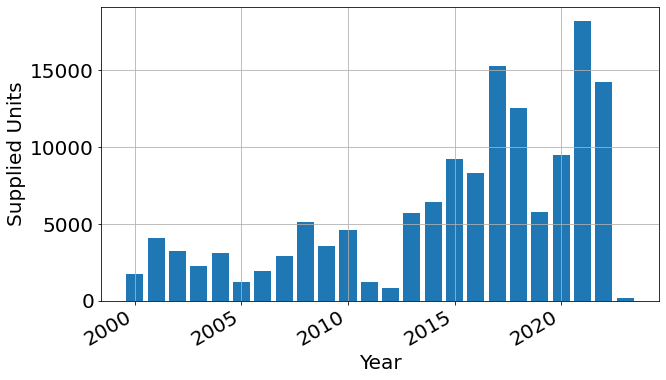

In [92]:
fig, ax = plt.subplots(figsize = (10,6))
plt.bar(result.index, result['Units Supplied'])

fig.autofmt_xdate()
plt.grid()
plt.xlabel('Year')
plt.ylabel('Supplied Units')
plt.show()

In [93]:
pop = pd.read_csv('population.csv')

In [94]:
pop = pop.drop(['Unnamed: 0'], axis=1)
pop.columns = ['Year', 'Population']
pop.Year = pop.Year.apply(lambda x: pd.to_datetime(x).year)
pop = pop.set_index('Year')

In [95]:
pop_newcon = result.join(pop, how='outer')

In [96]:
pop_newcon

,Units Supplied,Population
2000,1748,777885.0
2001,4104,780865.0
2002,3264,772723.0
2003,2296,766160.0
2004,3140,761325.0
2005,1218,763016.0
2006,1915,768650.0
2007,2922,778673.0
2008,5103,791152.0
2009,3586,801922.0


In [97]:
pop_newcon['Population Increase'] = pop_newcon['Population'].diff()
pop_newcon['Population Increase Cumulated'] = pop_newcon['Population']-pop_newcon.iloc[0]['Population']
pop_newcon = pop_newcon.rename(columns={'Units Supplied': 'New Residential Units'})
pop_newcon['New Residential Units Cumulated'] = pop_newcon["New Residential Units"].cumsum()

In [98]:
pop_newcon = pop_newcon[1:19]
pop_newcon

,New Residential Units,Population,Population Increase,Population Increase Cumulated,New Residential Units Cumulated
2001,4104,780865.0,2980.0,2980.0,5852
2002,3264,772723.0,-8142.0,-5162.0,9116
2003,2296,766160.0,-6563.0,-11725.0,11412
2004,3140,761325.0,-4835.0,-16560.0,14552
2005,1218,763016.0,1691.0,-14869.0,15770
2006,1915,768650.0,5634.0,-9235.0,17685
2007,2922,778673.0,10023.0,788.0,20607
2008,5103,791152.0,12479.0,13267.0,25710
2009,3586,801922.0,10770.0,24037.0,29296
2010,4614,805550.0,3628.0,27665.0,33910


In [99]:
pop_newcon.reset_index(inplace=True)

In [100]:
pop_newcon.to_csv('newcon.csv')

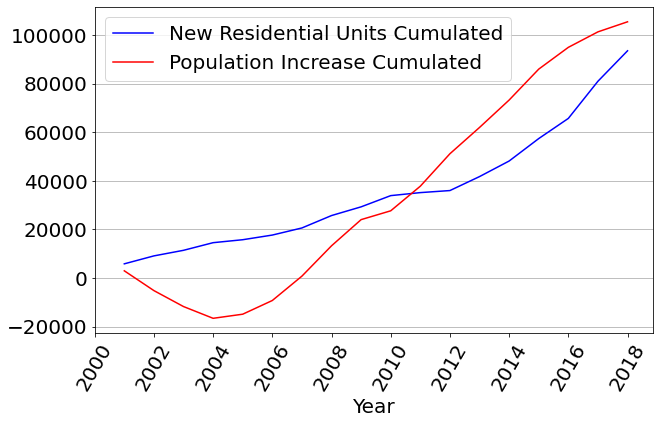

In [101]:
pop_newcon.plot(x = 'index', y=["New Residential Units Cumulated", "Population Increase Cumulated"], kind="line", rot=60, figsize=(10,6), 
          xlabel='Year', color={"New Residential Units Cumulated": "blue", "Population Increase Cumulated": "red"})
# plt.savefig('pop_newcon_cumulated.png')
plt.xticks(np.linspace(2000,2018,10))
plt.grid(axis='y')
plt.show()

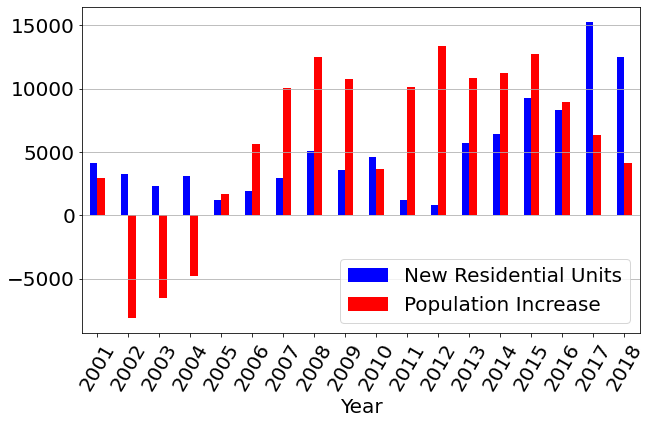

In [102]:
pop_newcon.plot(x = 'index', y=["New Residential Units", "Population Increase"], kind="bar", rot=60,figsize=(10,6), 
            xlabel='Year', color={"New Residential Units": "blue", "Population Increase": "red"})
# plt.savefig('pop_newcon.png')
plt.grid(axis='y')
plt.show()

San Francisco County has been constructing new residential units. However, the housing prices in San Francisco have continued to rise. This may indicate that either the new constructions are still insufficient or that the scarcity of houses is not the primary factor determining housing prices in San Francisco.')

## Poverty: Homeless population

In [103]:
# CoC number: CA-501
# 2008-2022
overallhomeless = {}
unsheltered = {}

for i in range(15):
    homeless = pd.read_excel('2007-2022-PIT-Counts-by-CoC.xlsx', sheet_name=i)
    overallhomeless[2022-i] = homeless[homeless['CoC Number']=='CA-501']['Overall Homeless, '+str(2022-i)].values[0]
    unsheltered[2022-i] = homeless[homeless['CoC Number']=='CA-501']['Unsheltered Homeless, '+str(2022-i)].values[0]  

In [104]:
overallhomeless

{2022: 7754.0,
 2021: 4000.0,
 2020: 8124.0,
 2019: 8035.0,
 2018: 6857.0,
 2017: 6858.0,
 2016: 6996.0,
 2015: 6775.0,
 2014: 6408.0,
 2013: 7008.0,
 2012: 5895.0,
 2011: 5669.0,
 2010: 5823.0,
 2009: 5823.0,
 2008: 5171.0}

In [105]:
homeless[homeless['CoC Number']=='CA-501']

,CoC Number,CoC Name,"Overall Homeless, 2008","Sheltered ES Homeless, 2008","Sheltered TH Homeless, 2008","Sheltered Total Homeless, 2008","Unsheltered Homeless, 2008","Overall Homeless Individuals, 2008","Sheltered ES Homeless Individuals, 2008","Sheltered TH Homeless Individuals, 2008",...,"Sheltered Total Homeless People in Families, 2008","Unsheltered Homeless People in Families, 2008","Overall Homeless Family Households, 2008","Sheltered ES Homeless Family Households, 2008","Sheltered TH Homeless Family Households, 2008","Sheltered Total Homeless Family Households, 2008","Unsheltered Homeless Family Households, 2008","Overall Chronically Homeless Individuals, 2008","Sheltered Total Chronically Homeless Individuals, 2008","Unsheltered Chronically Homeless Individuals, 2008"
20,CA-501,San Francisco CoC,5171.0,1818.0,582.0,2400.0,2771.0,4639.0,1496.0,392.0,...,512.0,20.0,194.0,113.0,73.0,186.0,8.0,1735.0,738.0,997.0


In [106]:
index = list(overallhomeless.keys())
col = list(overallhomeless.values())

In [107]:
temp = pd.DataFrame(data=col, index=index)
temp

,0
2022,7754.0
2021,4000.0
2020,8124.0
2019,8035.0
2018,6857.0
2017,6858.0
2016,6996.0
2015,6775.0
2014,6408.0
2013,7008.0


In [108]:
pop

,Population
Year,
2000,777885
2001,780865
2002,772723
2003,766160
2004,761325
2005,763016
2006,768650
2007,778673
2008,791152


In [109]:
homeless_df = pop
homeless_df['Homeless'] = temp[0]
homeless_df

,Population,Homeless
Year,,
2000,777885,NaN
2001,780865,NaN
2002,772723,NaN
2003,766160,NaN
2004,761325,NaN
2005,763016,NaN
2006,768650,NaN
2007,778673,NaN
2008,791152,5171.0


In [110]:
homeless_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 2000 to 2018
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Population  19 non-null     int64  
 1   Homeless    11 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1012.0 bytes


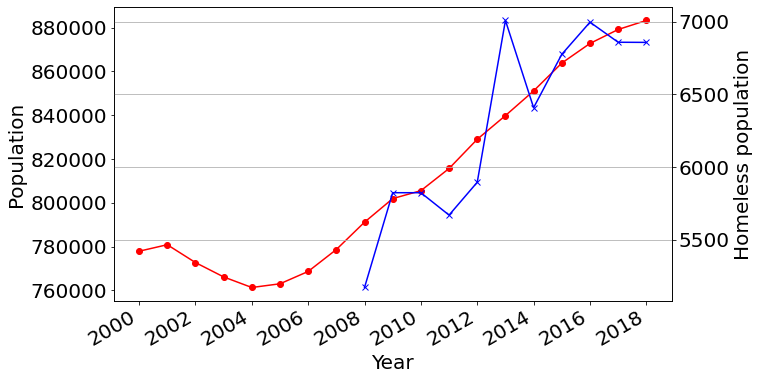

In [111]:
fig, ax1 = plt.subplots(figsize = (10,6))

ax1.plot(homeless_df.index, homeless_df['Population'], 'ro-', label='Population')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population')
ax1.set_xticks(np.linspace(2000,2018,10))

ax2 = ax1.twinx()
ax2.locator_params(axis='y', nbins=7)
ax2.plot(homeless_df.index, homeless_df['Homeless'], 'bx-', label='Homeless')
ax2.set_ylabel('Homeless population')
# ax2.set_yticks(np.linspace(5250,7100,7))
# ax2.set_ylim((5100, 7100))

fig.autofmt_xdate()
plt.grid()
# plt.savefig('homeless.png')
plt.show()

The rising number of homeless population in San Francisco may be linked to the city's growing population and the high cost of housing.

In this project, we can confirm that population growth may be a contributing factor to housing prices, but it is important to recognize that other variables can also have a significant impact on the housing costs. Factors such as economy or job opportunities may also play a significant role in driving the housing market.